# Tema 3: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 tipuri de cifre din setul MNIST.

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara. 
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. in definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

1. Optional:
    1. Folositi alt optimizator decat SGD, de ex. Adam. Comparati cu rezultatele obtinute pe SGD.
    1. Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se pana in 5 aprilie ora 23, in cadrul temei 3 de pe platforma. Modul de predare si de rpezentare aeste la fel ca pentru temele precedente.

Setting up the torch imports

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from torch.utils.data import Dataset

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1  Device: cpu


Setting up additional imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import Tuple

Define Dataset class

In [19]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Init the dataset from a csv (path) with the specfied no. of classes
        :param path_csv: path to the csv file
        :param classes: no. of classes
        """
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        self.path_csv = path_csv

        _all_digits = pd.read_csv(path_csv, header=None).values

        _y = _all_digits[:, 0]
        _x = _all_digits[:, 1:]
        _x = _x / 255

        self.x = torch.Tensor(_x)
        self.y = torch.Tensor(_y).long()

    def __len__(self):
        """
        Returns the length of the current dataset
        :return: the length
        """
        return len(self.y)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns (input, label) for the specified :param index
        :param index: The position from where the vector and its label is returned
        :return: pereche: input as a vector (784) and the classes (10) [0,1..9]
        """
        return self.x[index, :], self.y[index]

Define train and test dataset objects

In [20]:
train_ds = MNISTDataset('./data/mnist_train.csv', classes=10)
test_ds = MNISTDataset('./data/mnist_test.csv', classes=10)

print(len(train_ds))
print(len(test_ds))

60000
10000


Pipeline the data thru a DataLoader

In [21]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

for data, label in train_loader:
    print(data.shape, label.shape)
    break

torch.Size([32, 784]) torch.Size([32])


Definirea modelului

In [22]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, classes: int = 10):
        """
        Constructor for the model, calls parent constructor as well (nn.Module), initialize layers for the neural net
        :param input_size: input size for the model: int
        :param classes: expected output for the model: int
        """
        super(MultinomialLogisticRegression, self).__init__()
        self.input_size = input_size
        self.fully_connected = nn.Linear(input_size, classes)
    def forward(self, x):
        """
        The model makes a prediction then returns it
        :param x: input: Tensor
        :return: y: output: Tensor
        """
        return self.fully_connected(x)

Instantiem modelul

In [23]:
model = MultinomialLogisticRegression()
print(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


In [24]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

In [25]:
print(f'device={device}')
model.to(device)

device=cpu


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [26]:
@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Tests a model with data from a loader making computation on the specified device
    :param model: Multinomial logistic regression model
    :param loader: DataLoader for testing
    :param device: Where the model runs (cpu, gpu, tpu etc)
    :return: Accuracy%
    """
    correctly_classified = 0
    total_items = 0
    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        actual_class = y
        predicted_class = torch.argmax(y_hat, dim=1)

        correctly_classified += torch.sum((predicted_class == actual_class) * 1)
        total_items += len(x)
    accuracy = correctly_classified / total_items
    return accuracy.cpu().detach().item()

In [27]:
acc = test(model, test_loader, device)
print(f'Accuracy for the not trained model: {acc * 100}%')

Accuracy for the not trained model: 11.460000276565552%


In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=0.001)
loss_func = nn.CrossEntropyLoss()

In [29]:
epochs = 100
losses = []
accuracies = []

for epoch in range(epochs):

    model.train()
    epoch_loss = 0
    total_items = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        loss = loss_func(y_hat, y)
        epoch_loss += loss.item() * len(x)
        total_items += len(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    epoch_loss /= total_items
    losses.append(epoch_loss)
    print(f'Epoch: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')
    acc_test = test(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoch: {epoch + 1}/{epochs}: Accuracies for test set  = {acc_test * 100:.4f}%\n')

Epoch: 1/100: loss = 0.9802733
Epoch: 1/100: Accuracies for test set  = 86.5900%

Epoch: 2/100: loss = 0.5556970
Epoch: 2/100: Accuracies for test set  = 88.3600%

Epoch: 3/100: loss = 0.4760137
Epoch: 3/100: Accuracies for test set  = 89.0500%

Epoch: 4/100: loss = 0.4375369
Epoch: 4/100: Accuracies for test set  = 89.7000%

Epoch: 5/100: loss = 0.4136816
Epoch: 5/100: Accuracies for test set  = 89.9500%

Epoch: 6/100: loss = 0.3971505
Epoch: 6/100: Accuracies for test set  = 90.2500%

Epoch: 7/100: loss = 0.3847851
Epoch: 7/100: Accuracies for test set  = 90.4600%

Epoch: 8/100: loss = 0.3751047
Epoch: 8/100: Accuracies for test set  = 90.7000%

Epoch: 9/100: loss = 0.3673029
Epoch: 9/100: Accuracies for test set  = 90.8400%

Epoch: 10/100: loss = 0.3607808
Epoch: 10/100: Accuracies for test set  = 90.8800%

Epoch: 11/100: loss = 0.3552647
Epoch: 11/100: Accuracies for test set  = 90.9200%

Epoch: 12/100: loss = 0.3504782
Epoch: 12/100: Accuracies for test set  = 91.0500%

Epoch: 13/

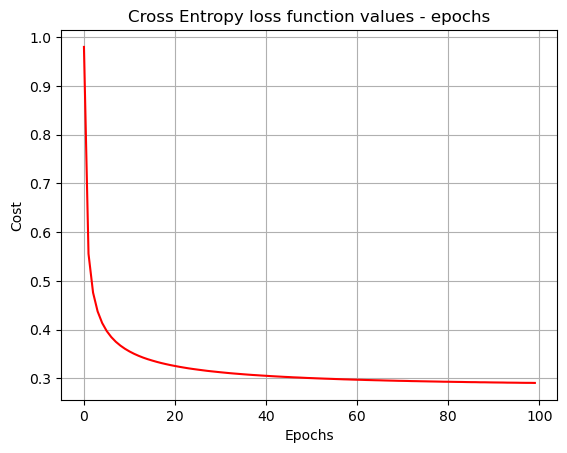

In [30]:
plt.plot(losses, color="red")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cross Entropy loss function values - epochs")
plt.grid()
plt.show()

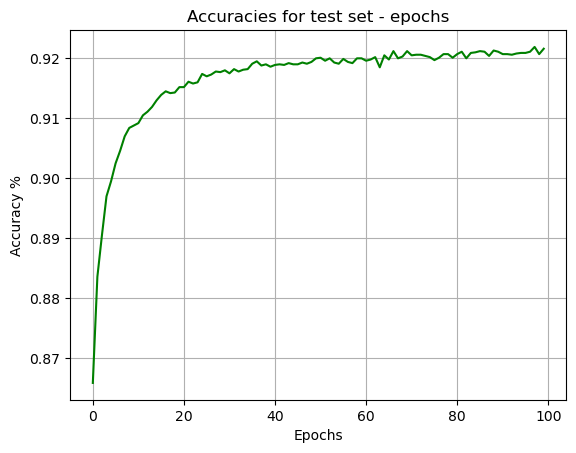

In [31]:
plt.plot(accuracies, color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracies for test set - epochs")
plt.grid()
plt.show()

In [32]:
confusion_matrix = torch.zeros(10, 10).long()
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        x.to(device), y.to(device)
        y_hat = model(x)

        actual_class = y
        predicted_class = torch.argmax(y_hat, dim=1)

        for i in range(len(actual_class)):
            confusion_matrix[actual_class[i], predicted_class[i]] += 1

import tableprint as tab
headers = ['CnfMat'] + [f'pr: {x}' for x in range(10)]
table = []
for i in range(10):
    row = [f'act: {i}'] + confusion_matrix[i, :].tolist()
    table.append(row)

tab.table(table, headers, width=6)
print("Accuracy for testing: ", 100 * test(model, test_loader, device))
print("Accuracy for training: ", 100 * test(model, train_loader, device))

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    963 │      0 │      2 │      1 │      0 │      3 │      8 │      1 │      2 │      0 │
│ act: 1 │      0 │   1108 │      2 │      2 │      0 │      2 │      4 │      2 │     15 │      0 │
│ act: 2 │      7 │      7 │    916 │     16 │     11 │      2 │     14 │     13 │     39 │      7 │
│ act: 3 │      3 │      1 │     24 │    918 │      0 │     25 │      2 │     12 │     18 │      7 │
│ act: 4 │      1 │      2 │      3 │      1 │    913 │      0 │     13 │      2 │      8 │     39 │
│ act: 5 │     10 │      3 │      3 │     34 │      9 │    768 │     18 │      7 │     33 │      7 │
│ act: 6 │     12 │      3 │      4 │      1 │      9 │     13 │    913 │      2 │      1 │